<a href="https://colab.research.google.com/github/NikolasGialitsis/ProteinsDistanceGeometry/blob/master/ProteinsDistanceGeometry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PDB coords extraction

In [4]:
Xtrain_coords = []
model_num = 1
molecules = ['1uwc.pdb','6fat.pdb']
mol_array = []
for mol in molecules:
  print('Get coords for molecule ',mol)
  array = []
  with open(mol) as pdbfile:
      for line in pdbfile:
          #print(line)
          if line[:5] == 'MODEL':
            print('Parsing  Molecule '+str(model_num))
            model_num = model_num + 1
            mol1 = []
          elif line[:4] == 'ATOM':
              #print(line)
              # Split the line
              x_list = line[30:38]
              y_list = line[38:46]
              z_list = line[46:54]

              x_str = ' '.join([str(elem) for elem in x_list]) 
              y_str = ' '.join([str(elem) for elem in y_list]) 
              z_str = ' '.join([str(elem) for elem in z_list]) 
              
              x_str_no_space = x_str.replace(" ", "")
              y_str_no_space = y_str.replace(" ", "")
              z_str_no_space = z_str.replace(" ", "")

              x_float = float(x_str_no_space)
              y_float = float(y_str_no_space)
              z_float = float(z_str_no_space)

              array.append((x_float,y_float,z_float))
      mol_array.append(array)   
      #print('x = '+str(x_float),'y = '+str(y_float), 'z = ' + str(z_float))


Get coords for molecule  1uwc.pdb


FileNotFoundError: ignored

## Calculate c-RMSD

In [0]:
import numpy as np



def euclidean_norm_power2(a,b):
  dim = len(a)
  assert(dim > 0)
  assert(dim == len(b))
  sum_sqrts = 0
  for d in range(dim):
    sum_sqrts += ((a[d] - b[d])*(a[d] - b[d]))
  assert(sum_sqrts >= 0)
  return sum_sqrts

def cRMSD(listX,listY):
  assert(len(listX) == len(listY))
  n = len(listX)
  assert(n > 0)
  sum_atoms = 0
  for ident in range(n):
    x = listX[ident]
    y = listY[ident]
    sum_atoms += euclidean_norm_power2(x,y)
  
  return np.sqrt(sum_atoms/n)

def getCentroid(atomsList):
  sum_atoms = []
  n = len(atomsList)
  dims = len(atomsList[0])
  for dim in range(dims):
    sum_atoms.append(np.array([atom[dim] for atom in atomsList]).sum()/n)
  return sum_atoms

def translateOrigin(atomsList):
  centroid = getCentroid(atomsList)
  for x in atomsList:
    for d in range(len(x)):
      x[d] -= centroid[d]

def GetImproved_cRMSD(X,Y):
  translateOrigin(X)
  translateOrigin(Y)
  XY = np.matmul(X.transpose(),Y)
  SVD = np.linalg.svd(XY)

  U = SVD[0]
  Sigma = SVD[1]
  V = SVD[2]


  Q = np.matmul(U,V)

  detQ = np.linalg.det(Q)
  if detQ < 0:
    U[2] = -U[2]
    Q = np.matmul(U,V)
    detQ = np.linalg.det(Q)
    assert(detQ >= 0)

  XQ = np.matmul(X,Q)
  final = cRMSD(XQ,Y)
  assert(final != float("inf"))
  assert(final != float("-inf"))
  assert(final >= 0)
  return final



## (C) construct Cayley-Menger (border) matrix B
Select 3 residues at the calcium binding site namely Val276-Ala277-Asp278 in the 3D
structure of Feruloyl esterase with PDB code 6FAT. Consider only their 3 backbone atoms
(smallest indices) namely atoms N, Ca, C of each, as points with 3D coordinates. Construct
the corresponding Cayley-Menger (border) matrix B of dimension 10x10.

In [6]:
with open('atom_coords.txt',mode='r',encoding='utf-8-sig') as f:
  data = f.readlines()
atoms = []
for line in data:
  x,y,z = line.split()
  atoms.append( (float(x),float(y),float(z)))
print(atoms)

[(19.456, 43.867, 53.82), (19.12, 44.932, 52.867), (19.18, 46.289, 53.576), (20.251, 47.037, 53.302), (20.462, 48.366, 53.881), (19.599, 49.411, 53.172), (18.326, 49.468, 53.563), (17.345, 50.411, 52.999), (16.733, 51.352, 54.051)]


In [8]:
import numpy as np
def BorderMatrix(atoms):
  num_atoms = len(atoms)
  array = -1 * np.ones(shape=(num_atoms+1,num_atoms+1))
  #print(array)
  for row in range(num_atoms+1):
    for col in range(num_atoms+1):
      if row == col:
        array[row,col] = 0
      elif row == 0 or col == 0:
        array[row,col] = 1 
      elif array[col,row] == -1:
        p1 = atoms[row-1]
        p2 = atoms[col-1]
        array[row,col] =  array[col,row] = 0.5* euclidean_norm_power2(p1,p2)
        
  assert(array.all() >= 0)
  return array

B = BorderMatrix(atoms)
for line in B.round(1):
  print(line)


[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[ 1.   0.   1.1  3.   5.5 10.6 15.6 16.4 24.  31.7]
[ 1.   1.1  0.   1.2  2.9  7.3 10.2 10.8 16.6 24.2]
[ 1.   3.   1.2  0.   0.9  3.   5.   5.4 10.3 15.9]
[ 1.   5.5  2.9  0.9  0.   1.1  3.   4.8 10.  15.8]
[ 1.  10.6  7.3  3.   1.1  0.   1.2  2.9  7.3 11.4]
[ 1.  15.6 10.2  5.   3.   1.2  0.   0.9  3.1  6.4]
[ 1.  16.4 10.8  5.4  4.8  2.9  0.9  0.   1.1  3.2]
[ 1.  24.  16.6 10.3 10.   7.3  3.1  1.1  0.   1.2]
[ 1.  31.7 24.2 15.9 15.8 11.4  6.4  3.2  1.2  0. ]


## D) Gram Matrix, SVD
 Check that rank(B)=5. Compute the Gram matrix G, and its SVD so as to get 3D point
coordinates. Check if it is the same structure, by computing its c-RMSD to (c).


In [9]:
rank = np.linalg.matrix_rank(B)
print('Border Matrix Rank = ',rank)
assert(rank==5)

Border Matrix Rank =  5


In [0]:
import numpy as np

def GramMatrix(B):
  n_rows,n_cols = B.shape
  G = np.zeros(shape=(n_rows-1,n_cols-1))
  o = 2 #origin
  for i in range(n_rows-1):
    for j in range(n_cols-1):
      G[i,j] = G[j,i] = B[i+1,o] - B[i+1,j+1] + B[j+1,o]
  return G




 Check if it is the same structure, by computing its c-RMSD to (c).


In [80]:
def getCoordsFromG(G):

  _,Sigma,V = np.linalg.svd(G)
  np.matrix.sort(Sigma) #sort ascending order
  Sigma = Sigma[::-1] #reverse array so that it is in descending order
  Sigma[3:] = 0
  Sigma = np.sqrt(np.array(Sigma))
  V = np.array(V)
  P = Sigma*V.transpose()
  P = P[:,:3]


  return P

G =  GramMatrix(B)
print(G.round(1))

P = getCoordsFromG(G)

print('Rank of P = ',\
      np.linalg.matrix_rank(P))
A = np.zeros(shape=(len(atoms),len(atoms[0])))
for i in range(len(atoms)):
  A[i,0],A[i,1],A[i,2] = atoms[i] 

print('cRMSD = ',GetImproved_cRMSD(P,A).round(1))

[[ 2.2  0.  -0.7 -1.4 -2.2 -4.3 -4.4 -6.3 -6.5]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [-0.7  0.   2.3  3.2  5.5  6.3  6.6  7.4  9.4]
 [-1.4  0.   3.2  5.9  9.2 10.1  9.   9.6 11.3]
 [-2.2  0.   5.5  9.2 14.6 16.3 15.2 16.6 20. ]
 [-4.3  0.   6.3 10.1 16.3 20.4 20.1 23.7 28. ]
 [-4.4  0.   6.6  9.  15.2 20.1 21.7 26.4 31.8]
 [-6.3  0.   7.4  9.6 16.6 23.7 26.4 33.2 39.6]
 [-6.5  0.   9.4 11.3 20.  28.  31.8 39.6 48.3]]
Rank of P =  3
cRMSD =  0.0


In [106]:

import random
def GetPerturbedMatrix(B,perturb_percent):
  B_perturbed = B.copy()
  n_rows,n_cols = B_perturbed.shape
  for row in range(n_rows):
    for col in range(n_cols):
      x = random.randint(1,2)
      if x % 2 == 0:
        B_perturbed[row,col] += perturb_percent *B_perturbed[row,col]
      else:
        B_perturbed[row,col] -= perturb_percent *B_perturbed[row,col]
  return B_perturbed


perturb_percent = 0
rmsd=0
perturb_mat  = []
while(rmsd <= 1):
  B_perturbed = GetPerturbedMatrix(B,perturb_percent)
  G = GramMatrix(B_perturbed)
  P = getCoordsFromG(G)
  rmsd = GetImproved_cRMSD(P,A).round(1)
  perturb_mat.append(perturb_percent)
  perturb_percent+=0.01
  print('Perturbation Percentage = %d%%'%(perturb_percent*100))
  print('\tc-RMSD =',rmsd.round(1))
print('Max Perturbation = %d%%'%(perturb_mat[-1]*100))

Perturbation Percentage = 1%
	c-RMSD = 0.0
Perturbation Percentage = 2%
	c-RMSD = 0.1
Perturbation Percentage = 3%
	c-RMSD = 0.1
Perturbation Percentage = 4%
	c-RMSD = 0.3
Perturbation Percentage = 5%
	c-RMSD = 0.3
Perturbation Percentage = 6%
	c-RMSD = 0.9
Perturbation Percentage = 7%
	c-RMSD = 0.3
Perturbation Percentage = 8%
	c-RMSD = 0.9
Perturbation Percentage = 9%
	c-RMSD = 1.1
Max Perturbation = 8%


Min threshold for c-RMSD < 1 = 30.00


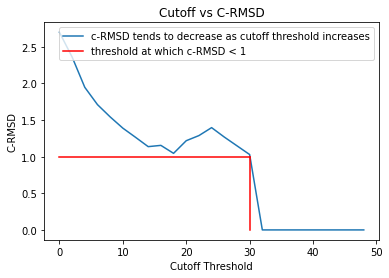

In [261]:
import matplotlib.pyplot as plt

def apply_cutoff(B,cutoff):
  n_rows,n_cols = B.shape
  B_cut = B.copy()
  for row in range(n_rows):
    new_row = []
    for col in range(n_cols):    
      if row > col:
        if B[row,col] > cutoff:
          B_cut[row,col] = B_cut[col,row] = cutoff

  return B_cut

rmsds = []
cutoffs = []
max_cutoff = 50
min_th = -1
for _ in range (int(max_cutoff/2)):
  if len(cutoffs) == 0:
    cutoffs.append(0)
  else:
    cutoffs.append(cutoffs[-1] + 2)
  cutoff = cutoffs[-1]
  B_cut = apply_cutoff(B,cutoff)
  G = GramMatrix(B_cut)
  P = getCoordsFromG(G)
  rmsd = GetImproved_cRMSD(P,A)
  rmsds.append(rmsd)

  if rmsd < 1  and min_th < 0: 
    print('Min threshold for c-RMSD < 1 = %.2f'%cutoffs[-2])
    min_th = cutoffs[-2]
  elif rmsd > 1:
    min_th = -1    
  
plt.figure(1)
plt.title('Cutoff vs C-RMSD')
plt.xlabel('Cutoff Threshold')
plt.ylabel('C-RMSD')
plt.plot(cutoffs,rmsds,label='c-RMSD tends to decrease as cutoff threshold increases')
plt.plot([min_th]*11,np.arange(0,1.1,0.1).tolist(),'r',label='threshold at which c-RMSD < 1')
plt.plot(np.arange(0,min_th+1,1).tolist(),[1]*(min_th+1),'r')
plt.legend()
plt.show()